In [156]:
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.layers import Dense, LSTM, Embedding, TextVectorization, Dropout, Bidirectional
from keras.preprocessing.text import one_hot 
from keras.models import Sequential,model_from_json,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os




# Check if GPU is used

In [157]:
d =tf.test.gpu_device_name()
print(d)

/device:GPU:0


Mounting the Drive

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading Data

In [159]:
os.getcwd()

'/content/drive/My Drive/ToxicCommentClassification'

In [151]:
os.chdir('/content/drive/MyDrive/ToxicCommentClassification')

In [160]:
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [161]:
os.getcwd()


'/content/drive/MyDrive/ToxicCommentClassification'

In [162]:
train.head()
df = train.drop(columns=['id'])

In [163]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [165]:
df.shape

(159571, 7)

# Data Preprocessing

In [166]:
x = df['comment_text']
y = df[df.columns[1:]]

In [167]:
y_arr =y.values #converting the df to array

In [168]:
MAX_FEATURE = 10000 #VOCAB SIZE

In [169]:
vectorizer = TextVectorization(
    max_tokens= MAX_FEATURE,
    output_sequence_length=500,
    output_mode='int'
    )

In [170]:
vectorizer.adapt(x.values)

In [171]:
vectorizer('hello world fuck you man')[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([288, 263, 139,   7, 441,   0,   0,   0,   0,   0])>

In [173]:
vectorized_text = vectorizer(x.values)


In [174]:
x.values.shape

(159571,)

In [175]:
vectorized_text #vectorizer pads up the remaining word places with 0

<tf.Tensor: shape=(159571, 500), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

In [176]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y_arr))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [177]:
batch_X, batch_Y = dataset.as_numpy_iterator().next()

In [178]:
len(dataset)#its batches (16)

9974

In [179]:
len(batch_X[9])

500

In [180]:
train= dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test= dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [181]:
len(train),len(val),len(test)

(6981, 1994, 997)

In [182]:
train_generator = train.as_numpy_iterator()

# Model Building

In [183]:

model = Sequential()

#Input Embedding Layer +1 is for the Unkown token
model.add(Embedding(MAX_FEATURE+1,32))

#layer of LSTM
#model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(64,activation='tanh',return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='tanh')))

#layer of Fully connected Networks
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

#Final 6 classifier nuerons
model.add(Dense(6,activation='sigmoid'))





In [184]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam',metrics=['accuracy'])

In [185]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)              

Model Check point and Early Stopping

In [186]:
es = EarlyStopping(monitor = 'val_loss', mode= 'min',verbose=1, patience =2)
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

In [187]:
history= model.fit(train,epochs=7,validation_data=val,verbose=2,callbacks=[es,mc]) 

Epoch 1/7

Epoch 1: val_accuracy improved from -inf to 0.99423, saving model to best_model.h5
6981/6981 - 476s - loss: 0.0692 - accuracy: 0.9879 - val_loss: 0.0502 - val_accuracy: 0.9942 - 476s/epoch - 68ms/step
Epoch 2/7

Epoch 2: val_accuracy did not improve from 0.99423
6981/6981 - 467s - loss: 0.0499 - accuracy: 0.9927 - val_loss: 0.0507 - val_accuracy: 0.9941 - 467s/epoch - 67ms/step
Epoch 3/7

Epoch 3: val_accuracy did not improve from 0.99423
6981/6981 - 462s - loss: 0.0465 - accuracy: 0.9942 - val_loss: 0.0474 - val_accuracy: 0.9936 - 462s/epoch - 66ms/step
Epoch 4/7

Epoch 4: val_accuracy did not improve from 0.99423
6981/6981 - 464s - loss: 0.0437 - accuracy: 0.9939 - val_loss: 0.0490 - val_accuracy: 0.9935 - 464s/epoch - 66ms/step
Epoch 5/7

Epoch 5: val_accuracy did not improve from 0.99423
6981/6981 - 461s - loss: 0.0414 - accuracy: 0.9939 - val_loss: 0.0467 - val_accuracy: 0.9938 - 461s/epoch - 66ms/step
Epoch 6/7

Epoch 6: val_accuracy did not improve from 0.99423
6981/6

In [188]:
saved_model = load_model('best_model.h5')
print("Model loaded Successfully")

Model loaded Successfully


In [39]:
'''# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")'''

Saved model to disk
Loaded model from disk


In [189]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320032    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)              

In [154]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

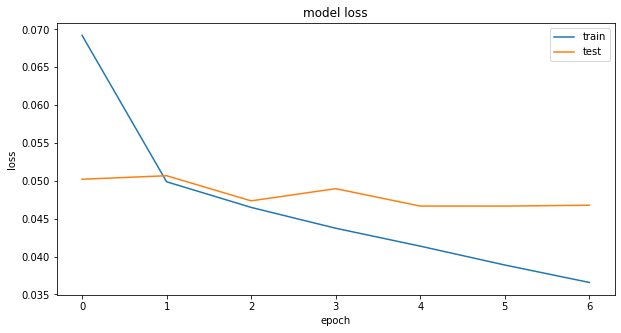

In [190]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

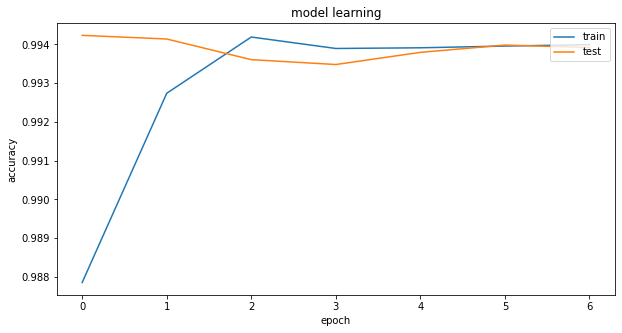

In [191]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model learning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Predictions

In [75]:
input_text =vectorizer('KILL YOU KILL KILL')

In [76]:
input_text[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([950,   7, 950, 950,   0,   0,   0,   0,   0,   0])>

In [77]:
model.predict(np.array([input_text])) #[] to make it batch and converting it into array 
                                       #before passing it into the model.


1/1 [==============================] - 0s 85ms/step


array([[0.8732789 , 0.05422688, 0.12278362, 0.391017  , 0.15316579,
        0.2270522 ]], dtype=float32)

In [80]:
df.columns[1:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [82]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [83]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 70ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [84]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

# Model Evaluation

In [192]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [193]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [194]:
for batch in test.as_numpy_iterator():
    x_true,y_true = batch #unpacking the calues
    yhat = model.predict(x_true)

    y_true = y_true.flatten()#to pass as one vector we are flattening
    yhat = yhat.flatten()

    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 52ms/step


In [195]:
print(f' Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy:{acc.result().numpy()}')

 Precision: 0.8090241551399231, Recall: 0.660479724407196, Accuracy:0.45837512612342834


In [218]:

a='sda'

In [221]:
str.upper(a)

'SDA'

In [222]:
def toxicity_classifier(comment):
    vectorized_comment = vectorizer(comment)
    results = loaded_model.predict(np.array([vectorized_comment]))
    text =''
    for idx, col in enumerate(df.columns[1:]):
        text += "*{}: {} ".format(str.upper(col),results[0][idx]>0.5)
    return text

In [223]:
loaded_model.predict(np.array([vectorizer('fuck you')]))

1/1 [==============================] - 0s 56ms/step


array([[0.9994758 , 0.2490225 , 0.9932777 , 0.00102633, 0.69249344,
        0.0043807 ]], dtype=float32)

In [224]:
toxicity_classifier('fuck you')

1/1 [==============================] - 0s 59ms/step


'*TOXIC: True *SEVERE_TOXIC: False *OBSCENE: True *THREAT: False *INSULT: True *IDENTITY_HATE: False '

In [133]:
.# Gradio App

import gradio as gr

In [137]:
interface = gr.Interface(
    fn= toxicity_classifier, 
    inputs = gr.inputs.Textbox(lines=2, placeholder='Toxicity Classifier'),
    outputs='text'         
             )

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [139]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://c17d097c5d1ae25d.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f3ff5966e90>,
 'http://127.0.0.1:7860/',
 'https://c17d097c5d1ae25d.gradio.app')

In [140]:
interface.close()

Closing server running on port: 7860
